Imports

In [4]:
import pandas as pd

Read File

In [38]:
file_path='./data/CTG.xls'
df_data_clean = pd.read_excel(file_path,'Data')
df_raw = pd.read_excel(file_path,'Raw Data',skiprows=[1,2])

In [39]:
df_raw.columns.equals(df_data_clean.columns)

False

In [40]:
df_raw.columns

Index(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC',
       'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP',
       'CLASS', 'NSP'],
      dtype='object')

Data Cleaning

In [41]:
df_raw.isnull().values.any() #faster than isna or sum

True

In [42]:
df_raw.columns[df_raw.isnull().any()].tolist()

['FileName',
 'Date',
 'SegFile',
 'b',
 'e',
 'LBE',
 'LB',
 'AC',
 'FM',
 'UC',
 'ASTV',
 'MSTV',
 'ALTV',
 'MLTV',
 'DL',
 'DS',
 'DP',
 'DR',
 'Width',
 'Min',
 'Max',
 'Nmax',
 'Nzeros',
 'Mode',
 'Mean',
 'Median',
 'Variance',
 'Tendency',
 'A',
 'B',
 'C',
 'D',
 'E',
 'AD',
 'DE',
 'LD',
 'FS',
 'SUSP',
 'CLASS',
 'NSP']

In [43]:
df_raw['FileName']

0         Fmcs_1.txt
1         Fmcs_1.txt
2         Fmcs_1.txt
3         Fmcs_1.txt
4         Fmcs_2.txt
            ...     
2123    S8001045.dsp
2124    S8001045.dsp
2125             NaN
2126             NaN
2127             NaN
Name: FileName, Length: 2128, dtype: object

In [44]:
df_raw = df_raw.iloc[:-3,:]

In [46]:
df_raw['FileName'].isnull().any()

False

In [47]:
df_raw.isnull().values.any() #faster than isna or sum

False

Data analysis

In [50]:
measure_columns = ["b","e","LBE","LB","AC","FM","UC","ASTV","MSTV","ALTV","MLTV","DL","DS","DP","DR","Width","Min","Max","Nmax","Nzeros","Mode","Mean","Median","Variance","Tendency"]
measure_columns_no_aggregates = ["b","e","LBE","LB","AC","FM","UC","ASTV","MSTV","ALTV","MLTV","DL","DS","DP","DR"]
df_raw_measures = df_raw.loc[:,measure_columns]
df_raw_measures_no_aggregates = df_raw.loc[:,measure_columns_no_aggregates]

In [54]:
print(df_raw_measures_no_aggregates)

           b       e    LBE     LB   AC   FM    UC  ASTV  MSTV  ALTV  MLTV  \
0        5.0   632.0  132.0  132.0  4.0  0.0   4.0  17.0   2.1   0.0  10.4   
1      177.0   779.0  133.0  133.0  2.0  0.0   5.0  16.0   2.1   0.0  13.4   
2      411.0  1192.0  134.0  134.0  2.0  0.0   6.0  16.0   2.4   0.0  23.0   
3      533.0  1147.0  132.0  132.0  4.0  0.0   5.0  16.0   2.4   0.0  19.9   
4        0.0   953.0  134.0  134.0  1.0  0.0  10.0  26.0   5.9   0.0   0.0   
...      ...     ...    ...    ...  ...  ...   ...   ...   ...   ...   ...   
2120  2059.0  2867.0  140.0  140.0  0.0  0.0   6.0  79.0   0.2  25.0   7.2   
2121  1576.0  2867.0  140.0  140.0  1.0  0.0   9.0  78.0   0.4  22.0   7.1   
2122  1576.0  2596.0  140.0  140.0  1.0  0.0   7.0  79.0   0.4  20.0   6.1   
2123  1576.0  3049.0  140.0  140.0  1.0  0.0   9.0  78.0   0.4  27.0   7.0   
2124  2796.0  3415.0  142.0  142.0  1.0  1.0   5.0  74.0   0.4  36.0   5.0   

       DL   DS   DP   DR  
0     2.0  0.0  0.0  0.0  
1     2.0

In [63]:
(df_raw_measures_no_aggregates["DR"]==0).all()

True

In [56]:
df_raw_measures_no_aggregates.corr()

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR
b,1.000000,0.945005,-0.020866,-0.020866,-0.038626,-0.133932,0.225278,-0.125929,0.040201,-0.109352,-0.100410,0.091591,0.063966,0.091609,NaN
e,0.945005,1.000000,-0.014913,-0.014913,0.071096,-0.119442,0.386322,-0.065412,0.043995,-0.103469,-0.108922,0.162924,0.068215,0.111789,NaN
LBE,-0.020866,-0.014913,1.000000,1.000000,-0.078498,-0.033444,-0.128646,0.306830,-0.280386,0.287120,-0.032768,-0.156390,-0.053577,-0.117358,NaN
LB,-0.020866,-0.014913,1.000000,1.000000,-0.078498,-0.033444,-0.128646,0.306830,-0.280386,0.287120,-0.032768,-0.156390,-0.053577,-0.117358,NaN
AC,-0.038626,0.071096,-0.078498,-0.078498,1.000000,0.053894,0.211749,-0.197574,0.191105,-0.344824,-0.129321,-0.011579,-0.039367,-0.110432,NaN
FM,-0.133932,-0.119442,-0.033444,-0.033444,0.053894,1.000000,-0.036758,-0.116386,0.138004,-0.072105,0.020942,0.076233,-0.010334,0.205318,NaN
UC,0.225278,0.386322,-0.128646,-0.128646,0.211749,-0.036758,1.000000,-0.078809,0.232255,-0.246707,-0.107281,0.339267,0.018378,0.152292,NaN
ASTV,-0.125929,-0.065412,0.306830,0.306830,-0.197574,-0.116386,-0.078809,1.000000,-0.430355,0.458727,-0.314620,-0.036615,0.034008,0.053900,NaN
MSTV,0.040201,0.043995,-0.280386,-0.280386,0.191105,0.138004,0.232255,-0.430355,1.000000,-0.469917,0.073469,0.516778,0.034112,0.287493,NaN
ALTV,-0.109352,-0.103469,0.287120,0.287120,-0.344824,-0.072105,-0.246707,0.458727,-0.469917,1.000000,-0.170414,-0.265993,-0.030745,-0.140013,NaN


Why is DR NaN?

In [59]:
corr_m = df_raw_measures_no_aggregates.corr().fillna(0) # DR is removed since p(K-W)=1

In [60]:
corr_m

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,DR
b,1.000000,0.945005,-0.020866,-0.020866,-0.038626,-0.133932,0.225278,-0.125929,0.040201,-0.109352,-0.100410,0.091591,0.063966,0.091609,0.0
e,0.945005,1.000000,-0.014913,-0.014913,0.071096,-0.119442,0.386322,-0.065412,0.043995,-0.103469,-0.108922,0.162924,0.068215,0.111789,0.0
LBE,-0.020866,-0.014913,1.000000,1.000000,-0.078498,-0.033444,-0.128646,0.306830,-0.280386,0.287120,-0.032768,-0.156390,-0.053577,-0.117358,0.0
LB,-0.020866,-0.014913,1.000000,1.000000,-0.078498,-0.033444,-0.128646,0.306830,-0.280386,0.287120,-0.032768,-0.156390,-0.053577,-0.117358,0.0
AC,-0.038626,0.071096,-0.078498,-0.078498,1.000000,0.053894,0.211749,-0.197574,0.191105,-0.344824,-0.129321,-0.011579,-0.039367,-0.110432,0.0
FM,-0.133932,-0.119442,-0.033444,-0.033444,0.053894,1.000000,-0.036758,-0.116386,0.138004,-0.072105,0.020942,0.076233,-0.010334,0.205318,0.0
UC,0.225278,0.386322,-0.128646,-0.128646,0.211749,-0.036758,1.000000,-0.078809,0.232255,-0.246707,-0.107281,0.339267,0.018378,0.152292,0.0
ASTV,-0.125929,-0.065412,0.306830,0.306830,-0.197574,-0.116386,-0.078809,1.000000,-0.430355,0.458727,-0.314620,-0.036615,0.034008,0.053900,0.0
MSTV,0.040201,0.043995,-0.280386,-0.280386,0.191105,0.138004,0.232255,-0.430355,1.000000,-0.469917,0.073469,0.516778,0.034112,0.287493,0.0
ALTV,-0.109352,-0.103469,0.287120,0.287120,-0.344824,-0.072105,-0.246707,0.458727,-0.469917,1.000000,-0.170414,-0.265993,-0.030745,-0.140013,0.0


In [55]:
numeric_df = df_raw_measures_no_aggregates.apply(pd.to_numeric, errors='coerce')
numeric_df.isnull().values.any()

False

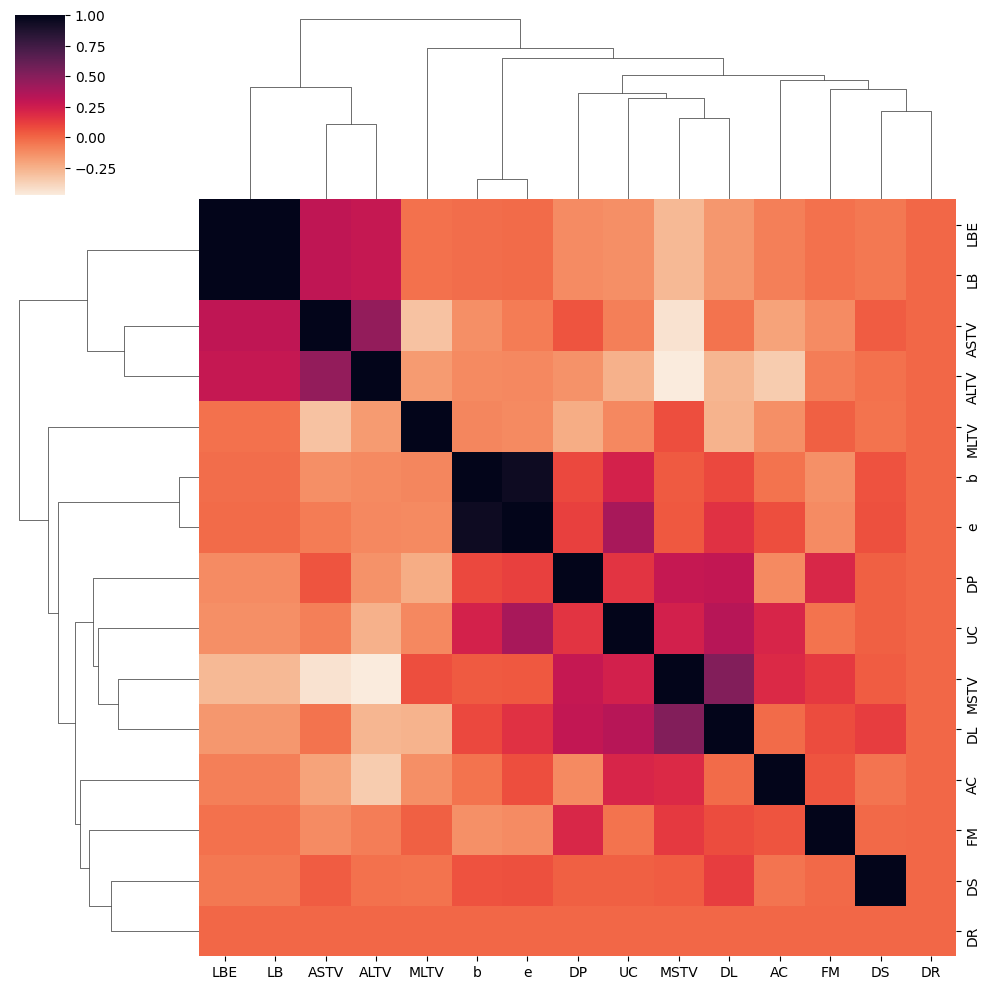

In [61]:
import seaborn as sns
sns_plot = sns.clustermap(corr_m, cmap="rocket_r")

In [ ]:
#DR will be dropped